In [821]:
import requests
from bs4 import BeautifulSoup
import unicodedata
import pandas as pd
import time
import random
import os
import shutil
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px

In [263]:
SLEEP_UPPER_BOUND = 5

# Scrape Data

### Find individual match links per world cup

In [215]:
def find_scorecard_links(year_fp):
    time.sleep(random.randint(0,SLEEP_UPPER_BOUND))
    
    page = requests.get(year_fp)
    assert(page.status_code == 200)
    
    soup = BeautifulSoup(page.content, "html.parser")
    scorecard_tags = soup.find_all(lambda tag: tag.get("class") == ["match-info-link-FIXTURES"])
    
    scorecard_links = []
    site_prefix = "https://www.espncricinfo.com"
    for link in scorecard_tags:
        scorecard_links.append(site_prefix + link.get("href"))

    return scorecard_links

### Find results per match

In [345]:
def find_full_match_results(scorecard_fp):
    time.sleep(random.randint(0,SLEEP_UPPER_BOUND))
    
    page = requests.get(scorecard_fp)
    assert(page.status_code == 200)
    
    soup = BeautifulSoup(page.content, "html.parser")
    
    match_info = soup.find("div", {"class":"match-info match-info-MATCH"})
    status = match_info.find("div", {"class":"status"})
    
    match_result_dict = {}
    match_result_dict["result"] = status.text
    match_result_dict["batsman"] = find_result_df(soup, "table batsman", 8)
    match_result_dict["bowler"] = find_result_df(soup, "table bowler", 11)
    
    return match_result_dict

In [341]:
def find_result_df(soup, class_name, expected_num_cols):
    time.sleep(random.randint(0,SLEEP_UPPER_BOUND))
    
    tables = soup.find_all("table", {"class":class_name})
    
    full_results = []
    for table in tables:
        table_rows = table.find_all("tr")

        result = []
        for tr in table_rows:
            tags = tr.find_all(["th", "td"])

            row = []
            for i in tags:
                text = i.text
                text = unicodedata.normalize("NFKD", text)
                text = text.encode("ascii", errors="ignore").decode()
                text = text.replace("(c)", "")
                text = text.strip()
                row.append(text)

            if len(row) == expected_num_cols:
                result.append(row)

        result_df = pd.DataFrame(result[1:], columns=result[0])
        full_results.append(result_df)

    return full_results

### Test individual match results

In [346]:
find_full_match_results("https://www.espncricinfo.com/series/icc-cricket-world-cup-2019-1144415/south-africa-vs-west-indies-15th-match-1144497/full-scorecard")

{'result': 'no result',
 'batsman': [           BATSMEN                       R   B   M 4s 6s     SR
  0  Quinton de Kock             not out  17  21  37  1  0  80.95
  1      Hashim Amla  c Gayle b Cottrell   6   7  13  1  0  85.71
  2    Aiden Markram   c Hope b Cottrell   5  10  16  1  0  50.00
  3   Faf du Plessis             not out   0   7   9  0  0   0.00],
 'bowler': [            BOWLING    O  M   R  W  ECON  0s 4s 6s WD NB
  0  Sheldon Cottrell    4  1  18  2  4.50  17  2  0  0  0
  1       Kemar Roach    3  0  10  0  3.33  13  1  0  1  0
  2     Oshane Thomas  0.3  0   1  0  2.00   2  0  0  0  0]}

In [347]:
find_full_match_results("https://www.espncricinfo.com/series/icc-cricket-world-cup-2019-1144415/india-vs-new-zealand-18th-match-1144500/full-scorecard")

{'result': 'abandoned', 'batsman': [], 'bowler': []}

In [352]:
find_full_match_results("https://www.espncricinfo.com/series/icc-cricket-world-cup-2019-1144415/australia-vs-sri-lanka-20th-match-1144502/full-scorecard")

{'result': 'result',
 'batsman': [          BATSMEN                           R    B    M  4s 6s      SR
  0    David Warner             b de Silva   26   48   70   2  0   54.17
  1     Aaron Finch  c Karunaratne b Udana  153  132  176  15  5  115.91
  2   Usman Khawaja     c Udana b de Silva   10   20   21   1  0   50.00
  3    Steven Smith              b Malinga   73   59   90   7  1  123.73
  4   Glenn Maxwell                not out   46   25   40   5  1  184.00
  5     Shaun Marsh  c Siriwardana b Udana    3    9   19   0  0   33.33
  6      Alex Carey        run out (Udana)    4    3    8   0  0  133.33
  7     Pat Cummins        run out (Udana)    0    1    4   0  0    0.00
  8  Mitchell Starc                not out    5    4    7   0  0  125.00,
                  BATSMEN                           R    B    M 4s 6s      SR
  0    Dimuth Karunaratne  c Maxwell b Richardson  97  108  132  9  0   89.81
  1          Kusal Perera                 b Starc  52   36   64  5  1  144.44
  2

### Loop over all world cups

In [372]:
world_cup_links = [
    "https://www.espncricinfo.com/series/prudential-world-cup-1975-60793/match-results",
    "https://www.espncricinfo.com/series/prudential-world-cup-1979-60806/match-results",
    "https://www.espncricinfo.com/series/prudential-world-cup-1983-60832/match-results",
    "https://www.espncricinfo.com/series/reliance-world-cup-1987-88-60876/match-results",
    "https://www.espncricinfo.com/series/benson-hedges-world-cup-1991-92-60924/match-results",
    "https://www.espncricinfo.com/series/wills-world-cup-1995-96-60981/match-results",
    "https://www.espncricinfo.com/series/icc-world-cup-1999-61046/match-results",
    "https://www.espncricinfo.com/series/icc-world-cup-2002-03-61124/match-results",
    "https://www.espncricinfo.com/series/icc-world-cup-2006-07-125929/match-results",
    "https://www.espncricinfo.com/series/icc-cricket-world-cup-2010-11-381449/match-results",
    "https://www.espncricinfo.com/series/icc-cricket-world-cup-2014-15-509587/match-results",
    "https://www.espncricinfo.com/series/icc-cricket-world-cup-2019-1144415/match-results",
]

In [373]:
year_labels = [
    "1975",
    "1979",
    "1983",
    "1987",
    "1991",
    "1995",
    "1999",
    "2003",
    "2007",
    "2011",
    "2015",
    "2019",
]

In [374]:
world_cup_results = {}
for year_fp, year_label in zip(world_cup_links, year_labels):
    scorecard_links = find_scorecard_links(year_fp)
    
    year_results = []
    for scorecard_fp in scorecard_links:
        year_results.append(find_full_match_results(scorecard_fp))

    world_cup_results[year_label] = year_results

### Save world cup results data

In [ ]:
world_cup_results

In [382]:
OVERWRITE_DATA = True

if OVERWRITE_DATA:
    shutil.rmtree("data/world_cup")
    
if not os.path.isdir("data/world_cup"):
    os.mkdir("data/world_cup")
    
    for year, matches in world_cup_results.items():
        print(f"{year} world cup: {len(matches)} matches")
        for match_number, match in enumerate(matches):
            
            # skip if there is no result for the match (e.g. match abandoned)
            if match["result"] != "result":
                print(f"- skipped {match_number}")
                continue
                
            save_dir = f"data/world_cup/{year}/{match_number}/"
            
            # make directory if it non-existent
            if not os.path.isdir(save_dir):
                os.makedirs(save_dir + "batsman/")
                os.makedirs(save_dir + "bowler/")
                
            try:
                # save both innings dataframes to directory
                match["batsman"][0].to_csv(save_dir + "batsman/innings_A.csv", index=False)
                match["batsman"][1].to_csv(save_dir + "batsman/innings_B.csv", index=False)
                match["bowler"][0].to_csv(save_dir + "bowler/innings_A.csv", index=False)
                match["bowler"][1].to_csv(save_dir + "bowler/innings_B.csv", index=False)
            except:
                print(f"- ERROR: skipped {match_number}")
                print(match)

1975 world cup: 15 matches
1979 world cup: 15 matches
- skipped 7
1983 world cup: 27 matches
1987 world cup: 27 matches
1991 world cup: 39 matches
- skipped 26
- skipped 30
1995 world cup: 38 matches
- skipped 22
- ERROR: skipped 24
{'result': 'result', 'batsman': [], 'bowler': []}
- ERROR: skipped 33
{'result': 'result', 'batsman': [], 'bowler': []}
1999 world cup: 42 matches
- skipped 9
2003 world cup: 54 matches
- skipped 13
- ERROR: skipped 33
{'result': 'result', 'batsman': [], 'bowler': []}
- skipped 38
- ERROR: skipped 46
{'result': 'result', 'batsman': [], 'bowler': []}
2007 world cup: 51 matches
2011 world cup: 49 matches
- skipped 29
2015 world cup: 49 matches
- skipped 38
2019 world cup: 48 matches
- skipped 30
- skipped 32
- skipped 33
- skipped 37


# Analyse data

In [435]:
all_batsmen = []
all_bowlers = []
for year in world_cup_results:
    cur_year_results = world_cup_results[year]
    
    cur_batsmen = []
    cur_bowlers = []
    for match in cur_year_results:
        cur_batsmen = cur_batsmen + match["batsman"]
        cur_bowlers = cur_bowlers + match["bowler"]
    
    cur_batsmen_df = pd.concat(cur_batsmen)
    cur_bowlers_df = pd.concat(cur_bowlers)

    cur_batsmen_df["Year"] = year
    cur_bowlers_df["Year"] = year
    
    all_batsmen.append(cur_batsmen_df)
    all_bowlers.append(cur_bowlers_df)

In [488]:
all_batsmen_df = pd.concat(all_batsmen)
all_bowlers_df = pd.concat(all_bowlers)

##### Clean up data

In [489]:
all_bowlers_df.columns = ("Bowler", "Overs", "Maidens", "Runs", "Wickets", "Economy", "0s", "4s", "6s", "Wides", "NoBalls", "Year")
all_bowlers_df = all_bowlers_df.replace("-", "0")
all_bowlers_df["Balls"] = all_bowlers_df["Overs"].str.split(".").apply(lambda x: 6*int(x[0]) if len(x) == 1 else 6*int(x[0])+int(x[1]))
all_bowlers_df[["Balls", "Maidens", "Runs", "Wickets", "0s", "4s", "6s", "Wides", "NoBalls", "Year"]] = all_bowlers_df[["Balls", "Maidens", "Runs", "Wickets", "0s", "4s", "6s", "Wides", "NoBalls", "Year"]].astype(int)
all_bowlers_df[["Economy"]] = all_bowlers_df[["Economy"]].astype(float)

In [490]:
all_batsmen_df.columns = ("Batsman", "Dismissal", "Runs", "Balls", "Minutes", "4s", "6s", "StrikeRate", "Year")
all_batsmen_df = all_batsmen_df.replace("-", "0")
all_batsmen_df[["Runs", "Balls", "Minutes", "4s", "6s", "Year"]] = all_batsmen_df[["Runs", "Balls", "Minutes", "4s", "6s", "Year"]].astype(int)
all_batsmen_df[["StrikeRate"]] = all_batsmen_df[["StrikeRate"]].astype(float)

In [491]:
all_batsmen_df.head()

,Batsman,Dismissal,Runs,Balls,Minutes,4s,6s,StrikeRate,Year
0,Roy Fredericks,hit wicket b Lillee,7,13,14,0,0,53.85,1975
1,Sir Gordon Greenidge,c Marsh b Thomson,13,61,80,1,0,21.31,1975
2,Alvin Kallicharran,c Marsh b Gilmour,12,18,26,2,0,66.67,1975
3,Rohan Kanhai,b Gilmour,55,105,156,8,0,52.38,1975
4,Sir Clive Lloyd,c Marsh b Gilmour,102,85,108,12,2,120.00,1975


In [492]:
all_bowlers_df.head()

,Bowler,Overs,Maidens,Runs,Wickets,Economy,0s,4s,6s,Wides,NoBalls,Year,Balls
0,Dennis Lillee,12,1,55,1,4.58,0,0,0,0,0,1975,72
1,Gary Gilmour,12,2,48,5,4.00,0,0,0,0,0,1975,72
2,Jeff Thomson,12,1,44,2,3.67,0,0,0,0,0,1975,72
3,Max Walker,12,1,71,0,5.92,0,0,0,0,0,1975,72
4,Greg Chappell,7,0,33,0,4.71,0,0,0,0,0,1975,42


##### Save full batsmen and bowler dataframes

In [493]:
all_batsmen_df.to_csv("data/all_batsmen.csv", index=False)
all_bowlers_df.to_csv("data/all_bowlers.csv", index=False)

### Find average runs per world cup

In [840]:
sum_batsmen_runs_df = all_batsmen_df.groupby(["Year", "Batsman"])["Runs"].sum().reset_index()

yearly_stddev_df = sum_batsmen_runs_df.groupby("Year")["Runs"].std().reset_index()
yearly_stddev_df.columns = ("Year", "StdDevRuns")
yearly_mean_df = sum_batsmen_runs_df.groupby("Year")["Runs"].mean().reset_index()
yearly_mean_df.columns = ("Year", "MeanRuns")

In [841]:
sum_batsmen_runs_df = sum_batsmen_runs_df.merge(yearly_stddev_df, on="Year")
sum_batsmen_runs_df = sum_batsmen_runs_df.merge(yearly_mean_df, on="Year")

In [842]:
sum_batsmen_runs_df["ZScore"] = (sum_batsmen_runs_df["Runs"] - sum_batsmen_runs_df["StdDevRuns"]) / sum_batsmen_runs_df["MeanRuns"]

In [843]:
sum_batsmen_runs_df.sort_values("ZScore", ascending=False).head(15)

,Year,Batsman,Runs,StdDevRuns,MeanRuns,ZScore
1004,2003,Sachin Tendulkar,673,106.631764,95.802030,5.911860
1168,2007,Matthew Hayden,659,124.092065,93.838863,5.700282
34,1975,Glenn Turner,333,60.826160,58.846939,4.625115
650,1995,Sachin Tendulkar,523,100.144122,91.864516,4.603038
1158,2007,Mahela Jayawardene,548,124.092065,93.838863,4.517403
1203,2007,Ricky Ponting,539,124.092065,93.838863,4.421494
609,1995,Mark Waugh,484,100.144122,91.864516,4.178500
175,1979,Sir Gordon Greenidge,253,55.085740,49.536082,3.995356
1214,2007,Scott Styris,499,124.092065,93.838863,3.995231
1431,2011,Tillakaratne Dilshan,500,109.992521,98.940594,3.941835


In [844]:
countries = {
    "Sachin Tendulkar":"India",
    "Matthew Hayden":"Australia",
    "Glenn Turner":"New Zealand",
    "Mahela Jayawardene":"Sri Lanka",
    "Ricky Ponting":"Australia",
    "Mark Waugh":"Australia",
    "Sir Gordon Greenidge":"West Indies",
    "Scott Styris":"New Zealand",
    "Tillakaratne Dilshan":"Sri Lanka",
    "Jacques Kallis":"South Africa",
    "Rahul Dravid":"India",
    "Aravinda de Silva":"Sri Lanka",
    "Martin Guptill":"New Zealand",
}

In [845]:
colours = {
    "India":"#B3E3EE",
    "Australia":"#F9D71C",
    "New Zealand":"black",
    "Sri Lanka":"#15295E",
    "West Indies":"#7b0041",
    "South Africa":"#007A4D",
    "Pakistan": "#006629",
}

In [847]:
plot_df = sum_batsmen_runs_df.sort_values("ZScore", ascending=False).head(15)
plot_df["Country"] = plot_df["Batsman"].apply(lambda x: countries[x])
plot_df["Colour"] = plot_df["Country"].apply(lambda x: colours[x])
plot_df["NameLabel"] = plot_df["Batsman"] + " (" + plot_df["Year"].astype(str) + ") "
plot_df["RunsLabel"] = plot_df["Runs"].astype(str) + " Runs"
fig = px.bar(
    plot_df, 
    x="ZScore", 
    y="NameLabel", 
    text="RunsLabel", 
    labels=dict(ZScore="Distance from the mean (z-score)", NameLabel=""),
    orientation="h",    
    color="Country",
    color_discrete_sequence=list(plot_df["Colour"].unique()),
).for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.update_traces(hoverinfo="skip")
fig.update_layout(showlegend=True)
fig.update_layout(yaxis_categoryorder="total ascending")
fig.update_layout(title="Best Cricket World Cup Batting Performances (1975-2019)")
fig.show()
pio.write_image(fig, "batting.png", width=1024, height=768, scale=5)

### Find average metric per world cup

In [823]:
metric = "Wickets" # Maidens

sum_bowlers_metric_df = all_bowlers_df.groupby(["Year", "Bowler"])[metric].sum().reset_index()

yearly_stddev_df = sum_bowlers_metric_df.groupby("Year")[metric].std().reset_index()
yearly_stddev_df.columns = ("Year", "StdDevMetric")
yearly_mean_df = sum_bowlers_metric_df.groupby("Year")[metric].mean().reset_index()
yearly_mean_df.columns = ("Year", "MeanMetric")

In [824]:
sum_bowlers_metric_df = sum_bowlers_metric_df.merge(yearly_stddev_df, on="Year")
sum_bowlers_metric_df = sum_bowlers_metric_df.merge(yearly_mean_df, on="Year")

In [825]:
sum_bowlers_metric_df["ZScore"] = (sum_bowlers_metric_df[metric] - sum_bowlers_metric_df["StdDevMetric"]) / sum_bowlers_metric_df["MeanMetric"]

In [826]:
# WICKETS
countries = {
    "Glenn McGrath": "Australia",
    "Shaun Tait": "Australia",
    "Muttiah Muralitharan": "Sri Lanka",
    "Brad Hogg": "Australia",
    "Mitchell Starc": "Australia",
    "Trent Boult": "New Zealand",
    "Chaminda Vaas": "Sri Lanka",
    "Zaheer Khan": "India",
    "Shahid Afridi": "Pakistan",
    "Brett Lee": "Australia",
    "Anil Kumble": "India",
    "Mitchell Starc": "Australia",
    "Glenn McGrath": "Australia",
    "Craig McDermott": "Australia",
    "Lasith Malinga": "Sri Lanka",
}

In [852]:
plot_df = sum_bowlers_metric_df.sort_values("ZScore", ascending=False).head(15)

In [839]:
plot_df["Country"] = plot_df["Bowler"].apply(lambda x: countries[x])
plot_df["Colour"] = plot_df["Country"].apply(lambda x: colours[x])
plot_df["NameLabel"] = plot_df["Bowler"] + " (" + plot_df["Year"].astype(str) + ") "
plot_df[f"{metric}Label"] = plot_df[metric].astype(str) + f" {metric}"
fig = px.bar(
    plot_df, 
    x="ZScore", 
    y="NameLabel", 
    text=f"{metric}Label", 
    labels=dict(ZScore="Distance from the mean (z-score)", NameLabel=""),
    orientation="h",    
    color="Country",
    color_discrete_sequence=list(plot_df["Colour"].unique()),
).for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.update_traces(hoverinfo="skip")
fig.update_layout(showlegend=True)
fig.update_layout(yaxis_categoryorder="total ascending")
fig.update_layout(title="Best Cricket World Cup Bowling Performances (1975-2019)")
fig.show()
pio.write_image(fig, "bowling.png", width=1024, height=768, scale=5)

### Approximating Normal?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123a7a358>]],
      dtype=object)

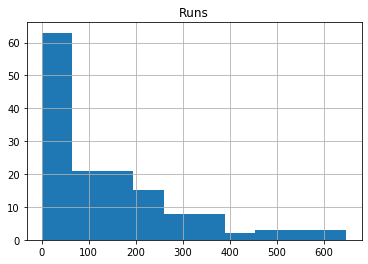

In [850]:
sum_batsmen_runs_df.query("Year == 2019").hist("Runs")